{'config_use_type': 'common', 'kline_type': 'kline_default', 'kline_qk': 'none', 'fx_qj': 'fx_qj_ck', 'fx_bh': 'fx_bh_no', 'bi_type': 'bi_type_old', 'bi_bzh': 'bi_bzh_yes', 'bi_qj': 'bi_qj_ck', 'bi_fx_cgd': 'bi_fx_cgd_no', 'xd_qj': 'xd_qj_ck', 'zsd_qj': 'zsd_qj_ck', 'zs_bi_type': ['zs_type_bz'], 'zs_xd_type': ['zs_type_bz'], 'zs_qj': 'zs_qj_ck', 'zs_wzgx': 'zs_wzgx_gd', 'zs_optimize': '0', 'idx_macd_fast': '12', 'idx_macd_slow': '26', 'idx_macd_signal': '9', 'fx_qy': 'fx_qy_middle', 'xd_zs_max_lines_split': '11', 'allow_split_one_line_to_xd': '0', 'allow_bi_fx_strict': '1', 'enable_kchart_low_to_high': '0', 'bi_split_k_cross_nums': '99,0', 'fx_check_k_nums': '99', 'cl_mmd_cal_qs_1mmd': '1', 'cl_mmd_cal_not_qs_3mmd_1mmd': '1', 'cl_mmd_cal_qs_3mmd_1mmd': '1', 'cl_mmd_cal_qs_not_lh_2mmd': '1', 'cl_mmd_cal_qs_bc_2mmd': '1', 'cl_mmd_cal_3mmd_not_lh_bc_2mmd': '1', 'cl_mmd_cal_1mmd_not_lh_2mmd': '1', 'cl_mmd_cal_3mmd_xgxd_not_bc_2mmd': '1', 'cl_mmd_cal_not_in_zs_3mmd': '1', 'cl_mmd_cal_not_in

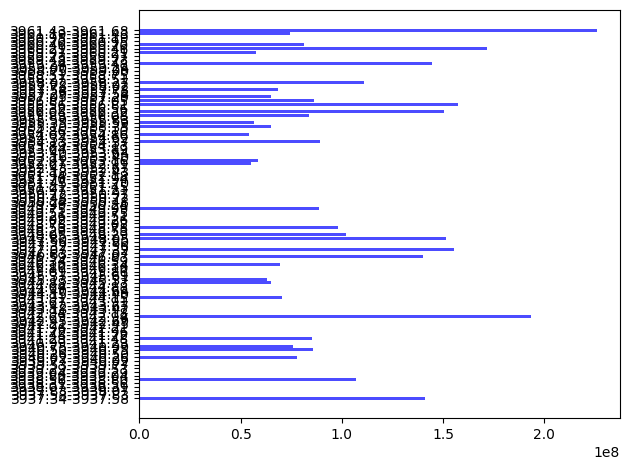

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import time

from chanlun import kcharts
from chanlun.cl_utils import query_cl_chart_config
from chanlun.exchange import get_exchange, Market
from chanlun.exchange.exchange_db import ExchangeDB
from chanlun import cl

import itertools
import talib
from chanlun.cl_utils import *
from chanlun.cl_interface import Config


# 市场
market = 'a'  # a 沪深A股  hk 港股 us 美股 futures 期货 currency 数字货币
# 标的代码
code = 'SHSE.000300'
# 获取周期，可设置多个
frequencys = ['1m']
# frequencys = ['30m','5m']
# 开始时间（需要api接口支持）
start_date = "2025-02-18 10:16:00"
# 结束时间（需要api接口支持）
end_date = "2025-02-18 11:01:00"
# 缠论计算配置
cl_config = query_cl_chart_config(market, code)
print(cl_config)
# ex = get_exchange(Market(market)) # 使用在线的k线数据接口
ex = ExchangeDB(market) # 读取数据库中的k线数据

klines = ex.klines(code, frequency=frequencys, start_date=start_date, end_date=end_date)
# 假设 klines 是一个已经定义的 DataFrame
df = klines[['date','open','high','low','close','volume']]

# 确保 'date' 列是 datetime 类型
df['date'] = pd.to_datetime(df['date'])

# 设置 'date' 列为索引
df.set_index('date', inplace=True)

# 绘制 K 线图
# mpf.plot(df, type='candle', volume=False, show_nontrading=False)

# 加权计算average_price
weights = {'open': 0.2, 'close': 0.2, 'high': 0.1, 'low': 0.1, 'open_close_avg': 0.2, 'all_avg': 0.2}
df['open_close_avg'] = (df['open'] + df['close']) / 2
df['all_avg'] = (df['open'] + df['close'] + df['high'] + df['low']) / 4
use_close = False
if use_close:
    df['average_price'] = df['close']
else:
    df['average_price'] = (df['open'] * weights['open'] +
                       df['close'] * weights['close'] +
                       df['high'] * weights['high'] +
                       df['low'] * weights['low'] +
                       df['open_close_avg'] * weights['open_close_avg'] +
                       df['all_avg'] * weights['all_avg'])

# 计算价格区间和成交量分布
bin_cnt = 100  # 默认间隔为1

min_price = df['average_price'].min()
max_price = df['average_price'].max()

# print(min_price, max_price)
interval = (max_price - min_price) / bin_cnt  # 确保 interval 是浮点数
bins = [min_price + i * interval for i in range(bin_cnt + 1)]
labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins) - 1)]

df['price_range'] = pd.cut(df['average_price'], bins=bins, labels=labels, right=False)
volume_by_price_range = df.groupby('price_range')['volume'].sum().reset_index()



# 找到成交量最高的价格区间及其对应的成交量
max_volume_range = volume_by_price_range.loc[volume_by_price_range['volume'].idxmax()]
idx = volume_by_price_range['volume'].idxmax()
print(f"成交量最高的价格区间: {max_volume_range['price_range']}, 成交量: {max_volume_range['volume']}")

# 计算所有价格区间的总成交量
total_volume = volume_by_price_range['volume'].sum()
# print(total_volume)
volume_sum = max_volume_range['volume']
part = 0.7
pre_idx = idx 
next_idx = idx
previous_element = volume_by_price_range.iloc[pre_idx]
next_element = volume_by_price_range.iloc[next_idx]
while volume_sum < part * total_volume:
    pre_volume_range = previous_element['price_range']
    next_volume_range = next_element['price_range']
    if pre_idx > 0:
        previous_element = volume_by_price_range.iloc[pre_idx - 1]
    if next_idx < len(volume_by_price_range) - 1:
        next_element = volume_by_price_range.iloc[next_idx + 1] 
        
    if previous_element['volume'] >= next_element['volume']:
        pre_idx -= 1
        pre_volume_range = previous_element['price_range']
        volume_sum += previous_element['volume']
    else:
        next_idx += 1
        next_volume_range = next_element['price_range']
        volume_sum += next_element['volume']

print(f"中枢区间{start_date}-{end_date}")
print(f"成交量占比{int(part*100)}的价格区间为{pre_volume_range.split('-')[0]}-{next_volume_range.split('-')[1]}")

# 绘制横向 FRVP 图表
plt.barh(volume_by_price_range['price_range'], volume_by_price_range['volume'], color='blue', alpha=0.7)

# 调整布局
plt.tight_layout()
plt.show()






In [ ]:
klines = ex.klines(code, frequency=frequencys, start_date=start_date, end_date=end_date)
# print(get_frvp(klines=klines,part=0.3))

In [8]:
get_frvp(klines)

成交量最高的价格区间: 3959.37-3959.61, 成交量占比: 7.0%
成交量占比70的价格区间为3942.95-3959.85


(3959.0, 3942.95, 3959.85)

In [ ]:
klines

In [ ]:
klines['date'][0]
# Timestamp('2025-02-13 10:54:00+0800', tz='Asia/Shanghai')

           code                      date      open      high       low  \
0   SHSE.000300 2025-02-18 10:16:00+08:00  3936.552  3938.171  3936.518   
1   SHSE.000300 2025-02-18 10:17:00+08:00  3938.085  3939.302  3937.895   
2   SHSE.000300 2025-02-18 10:18:00+08:00  3939.615  3941.626  3939.356   
3   SHSE.000300 2025-02-18 10:19:00+08:00  3941.148  3941.912  3940.307   
4   SHSE.000300 2025-02-18 10:20:00+08:00  3940.114  3940.411  3939.824   
5   SHSE.000300 2025-02-18 10:21:00+08:00  3940.286  3942.350  3940.286   
6   SHSE.000300 2025-02-18 10:22:00+08:00  3942.393  3943.317  3942.393   
7   SHSE.000300 2025-02-18 10:23:00+08:00  3942.980  3943.202  3941.923   
8   SHSE.000300 2025-02-18 10:24:00+08:00  3942.904  3945.350  3942.904   
9   SHSE.000300 2025-02-18 10:25:00+08:00  3945.336  3945.666  3944.462   
10  SHSE.000300 2025-02-18 10:26:00+08:00  3944.625  3945.786  3944.518   
11  SHSE.000300 2025-02-18 10:27:00+08:00  3945.936  3948.397  3945.936   
12  SHSE.000300 2025-02-1

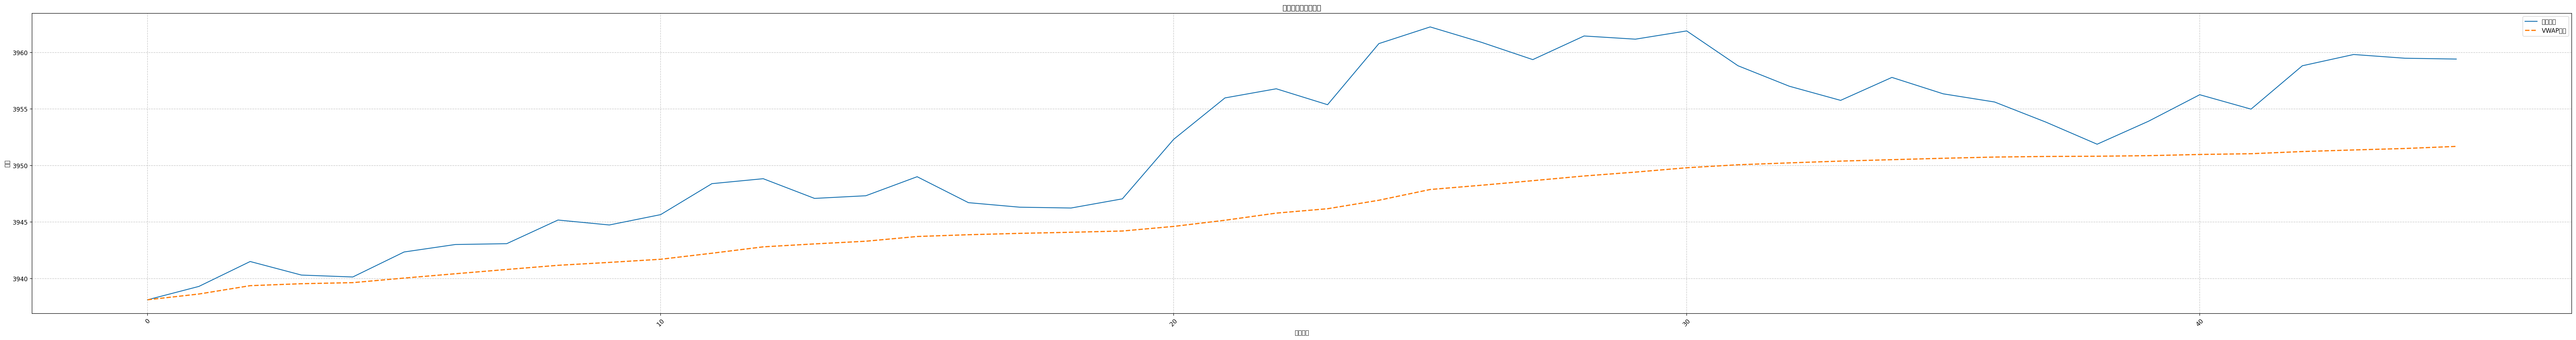

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import time

# # 生成模拟数据（假设已有1分钟K线数据）
# def generate_mock_data():
#     date_rng = pd.date_range(start='2025-03-07 09:30', end='2025-03-07 15:00', freq='1min')
#     np.random.seed(42)
#     close_prices = np.cumsum(np.random.randn(len(date_rng)) * 0.5) + 100
#     volume = np.random.randint(1000, 10000, size=len(date_rng))
    
#     df = pd.DataFrame({
#         'date': date_rng,
#         'open': close_prices - np.abs(np.random.randn(len(date_rng))),
#         'high': close_prices + np.abs(np.random.randn(len(date_rng))),
#         'low': close_prices - np.abs(np.random.randn(len(date_rng))),
#         'close': close_prices,
#         'volume': volume
#     })
#     return df

# 计算分时均线
def calculate_time_avg(df):
   
    # 提取日期部分并存储到 'datestr' 列
    df['datestr'] = df['date'].dt.strftime('%Y-%m-%d')

    # 提取时间部分并存储到 'time' 列
    df['time'] = df['date'].dt.strftime('%H:%M:%S')

    # 计算每日分时均价（累积平均）
    for datestr in df['datestr'].unique():
        # 计算累积成交量
        df.loc[df['datestr'] == datestr, 'cumulative_volume'] = df[df['datestr'] == datestr]['volume'].cumsum()
        
        # 计算累积成交金额
        df.loc[df['datestr'] == datestr, 'cumulative_amount'] = (df[df['datestr'] == datestr]['close'] * df[df['datestr'] == datestr]['volume']).cumsum()
        
        # 计算分时均价 (VWAP)
        df.loc[df['datestr'] == datestr, 'vwap'] = df.loc[df['datestr'] == datestr, 'cumulative_amount'] / df.loc[df['datestr'] == datestr, 'cumulative_volume']
    
    df['5_avg'] = df['close'].rolling(window=5).mean()
    df['10_avg'] = df['close'].rolling(window=10).mean()
    df['20_avg'] = df['close'].rolling(window=20).mean()
    df['30_avg'] = df['close'].rolling(window=30).mean()
    df['60_avg'] = df['close'].rolling(window=60).mean()
    df['90_avg'] = df['close'].rolling(window=90).mean()
    df['120_avg'] = df['close'].rolling(window=120).mean()
    df['250_avg'] = df['close'].rolling(window=250).mean()
    return df

# 绘制分时图
def plot_time_chart(df):
    plt.figure(figsize=(60, 8), dpi=200)
    
    # 转换时间格式
    # df['time_str'] = df['date'].dt.strftime('%H:%M')
    # x = mdates.date2num(df['date'])
    x=df.index    
    # 绘制价格线
    plt.plot(x, df['close'], label='分时价格', color='#1f77b4', linewidth=1.5)
    
    # 绘制均线
    plt.plot(x, df['vwap'], label='VWAP均线', color='#ff7f0e', linestyle='--', linewidth=2)
    # plt.plot(x, df['5_avg'], label='5分钟均线', color='#2ca02c', linewidth=1.5)
    # plt.plot(x, df['10_avg'], label='5分钟均线', color='#2ca02c', linewidth=1.5)
    # plt.plot(x, df['20_avg'], label='20分钟均线', color='#d62728', linewidth=1.5)
    # plt.plot(x, df['30_avg'], label='30分钟均线', color='#d62728', linewidth=1.5)
    # plt.plot(x, df['60_avg'], label='60分钟均线', color='#d62728', linewidth=1.5)
    # plt.plot(x, df['90_avg'], label='90分钟均线', color='#d62728', linewidth=1.5)
    # plt.plot(x, df['120_avg'], label='120分钟均线', color='#d62728', linewidth=1.5)
    # plt.plot(x, df['250_avg'], label='250分钟均线', color='#d62728', linewidth=1.5)

    
    # 设置坐标轴
    ax = plt.gca()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.xticks(rotation=45)
    plt.xlabel('交易时间')
    plt.ylabel('价格')
    plt.title('股票日内分时均线图')
    
    # 添加网格和标注
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # # 高亮交易时段
    # ax.axvspan(mdates.date2num(pd.to_datetime('2025-03-07 09:30')),
    #            mdates.date2num(pd.to_datetime('2025-03-07 11:30')), 
    #            color='green', alpha=0.05)
    # ax.axvspan(mdates.date2num(pd.to_datetime('2025-03-07 13:00')),
    #            mdates.date2num(pd.to_datetime('2025-03-07 15:00')), 
    #            color='blue', alpha=0.05)
    
    plt.tight_layout()
    plt.show()

# 主程序
if __name__ == "__main__":
    # 生成或加载数据（替换为实际数据）
    # df = generate_mock_data()
    df = klines
    # 计算指标
    df = calculate_time_avg(df)
    
    # 过滤非交易时间（可选）
    # df = df[(df['time'] >= time(9,30)) & (df['time'] <= time(15,0))]
    print(df.head(20))
    # 绘制图表
    plot_time_chart(df)


In [3]:
def get_frvp(klines, use_close=True, bin_cnt=100, part=0.7):
    df = klines
    # # 创建 DataFrame
    # df = []
    # for _k in klines:
    #     df.append(
    #         {
    #             "date": _k.date,
    #             "open": _k.o,
    #             "high": _k.h,
    #             "low": _k.l,
    #             "close": _k.c,
    #             "volume": _k.a,
    #         }
    #     )
    # if len(df) == 0:
    #     df = pd.DataFrame(
    #         [], columns=["date", "code", "high", "low", "open", "close", "volume"]
    #     )
    # else:
    #     df = pd.DataFrame(df)
    # 确保 'date' 列是 datetime 类型
    df['date'] = pd.to_datetime(df['date']) 
    # 设置 'date' 列为索引
    df.set_index('date', inplace=True)
    df['open_close_avg'] = (df['open'] + df['close']) / 2
    df['all_avg'] = (df['open'] + df['close'] + df['high'] + df['low']) / 4
    if use_close:
        df['average_price'] = df['close']
    else:
        # 加权计算average_price
        weights = {'open': 0.2, 'close': 0.2, 'high': 0.1, 'low': 0.1, 'open_close_avg': 0.2, 'all_avg': 0.2}
        df['average_price'] = (df['open'] * weights['open'] +
                        df['close'] * weights['close'] +
                        df['high'] * weights['high'] +
                        df['low'] * weights['low'] +
                        df['open_close_avg'] * weights['open_close_avg'] +
                        df['all_avg'] * weights['all_avg'])

    # 计算价格区间和成交量分布
    min_price = df['average_price'].min()
    max_price = df['average_price'].max()
    interval = (max_price - min_price) / bin_cnt  # 确保 interval 是浮点数
    bins = [min_price + i * interval for i in range(bin_cnt + 1)]
    labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins) - 1)]
    df['price_range'] = pd.cut(df['average_price'], bins=bins, labels=labels, right=False)
    volume_by_price_range = df.groupby('price_range')['volume'].sum().reset_index()
    
    # 计算所有价格区间的总成交量
    total_volume = volume_by_price_range['volume'].sum()
    
    # 找到成交量最高的价格区间及其对应的成交量
    max_volume_range = volume_by_price_range.loc[volume_by_price_range['volume'].idxmax()]
    idx = volume_by_price_range['volume'].idxmax()
    print(f"成交量最高的价格区间: {max_volume_range['price_range']}, 成交量占比: {round((max_volume_range['volume']/total_volume) * 100,0)}%")

    # 计算所有价格区间的总成交量
    total_volume = volume_by_price_range['volume'].sum()
    # print(total_volume)
    volume_sum = max_volume_range['volume']
    pre_idx = idx 
    next_idx = idx
    pre_volume_range = max_volume_range['price_range']
    next_volume_range = max_volume_range['price_range']
    while volume_sum < part * total_volume:
        if pre_idx > 0:
            previous_element = volume_by_price_range.iloc[pre_idx - 1]
        if next_idx < len(volume_by_price_range) - 1:
            next_element = volume_by_price_range.iloc[next_idx + 1] 
            
        if previous_element['volume'] >= next_element['volume']:
            pre_idx -= 1
            pre_volume_range = previous_element['price_range']
            volume_sum += previous_element['volume']
        else:
            next_idx += 1
            next_volume_range = next_element['price_range']
            volume_sum += next_element['volume']
    print(f"成交量占比{int(part*100)}的价格区间为{pre_volume_range.split('-')[0]}-{next_volume_range.split('-')[1]}")

    return round(
                    (float(max_volume_range['price_range'].split('-')[0]) 
                        + float(max_volume_range['price_range'].split('-')[1])
                    ) / 2, 0
                ), \
            float(pre_volume_range.split('-')[0]),\
            float(next_volume_range.split('-')[1])




